# Naive Bayes Classification

:label:`chapter_naive_bayes`


Before we worry about complex optimization algorithms or GPUs, we can already deploy our first classifier, relying only on simple statistical estimators and our understanding of conditional independence. Learning is all about making assumptions. If we want to classify a new data point that we've never seen before we have to make some assumptions about which data points are similar to each other. The naive Bayes classifier, a popular and remarkably simple algorithm, assumes all features are independent of each other to simplify the computation. In this chapter, we will apply this model to recognize characters in images.

Let's first import libraries and modules. Especially, we import `d2l`, which now contains the function `use_svg_display` we defined in :numref:`chapter_prob`.

In [1]:
%matplotlib inline
import d2l
import math
from mxnet import np, npx, gluon
npx.set_np()
d2l.use_svg_display()

## Optical Character Recognition

MNIST :cite:`LeCun.Bottou.Bengio.ea.1998` is one of widely used datasets. It contains 60,000 images for training and 10,000 images for validation. We will formally introduce training data in :numref:`chapter_linear_regression` and validation data in :numref:`chapter_model_selection` later, here we just simply remember we will train the naive Bayes model in the training data and then test its quality on the validation data. Each image contains a handwritten digit from 0 to 9. The task is classifying each image into the corresponding digit.

Gluon, MXNet's high-level interface for implementing neural networks, provides a `MNIST` class in the `data.vision` module to 
automatically retrieve the dataset via our Internet connection.
Subsequently, Gluon will use the already-downloaded local copy.
We specify whether we are requesting the training set or the test set
by setting the value of the parameter `train` to `True` or `False`, respectively.
Each image is a grayscale image with both width and height of 28 with shape $(28,28,1)$. We use a customized transformation to remove the last channel dimension. In addition, each pixel is presented by a unsigned 8-bit integer, we quantize them into binary features to simplify the problem.

In [2]:
np.floor?

In [3]:
def transform(data, label):
    return np.floor(data.astype('float32')/128).squeeze(axis=-1), label

mnist_train = gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test  = gluon.data.vision.MNIST(train=False, transform=transform)

We can access a particular example, which contains the image and the corresponding label.

In [4]:
image, label = mnist_train[2]
image.shape, label

((28, 28), array(4, dtype=int32))

Our example, stored here in the variable `image` corresponds to an image with a height and width of 28 pixels. Each pixel is an 8-bit unsigned integer (uint8) with values between 0 and 255. It is stored in a 3D ndarray, whose last dimension is the number of channels. Since the data set is a grayscale image, the number of channels is 1. When we encounter color, images, we'll have 3 channels for red, green, and blue. To keep things simple, we will record the shape of the image with the height and width of $h$ and $w$ pixels, respectively, as $h \times w$ or `(h, w)`.

In [5]:
image.shape, image.dtype

((28, 28), numpy.float32)

The label of each image is represented as a scalar in NumPy. Its type is a 32-bit integer.

In [6]:
label, type(label), label.dtype

(array(4, dtype=int32), mxnet.numpy.ndarray, numpy.int32)

We can also access multiple examples at the same time.

In [7]:
images, labels = mnist_train[10:38]
images.shape, labels.shape

((28, 28, 28), (28,))

Now let's create a function to visualize these examples.

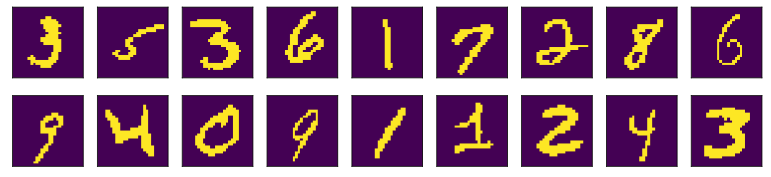

In [8]:
# Save to the d2l package. 
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

show_images(images, 2, 9);

## The Probabilistic Model for Classification

In a classification task, we map an example into a category. Here an example is a grayscale $28\times 28$ image, and a category is a digit. (Refer to :numref:`chapter_softmax` for a more detailed explanation.) 
One natural way to express the classification task is via the probabilistic question: what is the most likely label given the features (i.e. image pixels)? Denote by $\mathbf x\in\mathbb R^d$ the features of the example and $y\in\mathbb R$ the label. Here features are image pixels, where we can reshape a 2-dimensional image to a vector so that $d=28^2=784$, and labels are digits. We will formally define general features and labels in :numref:`chapter_linear_regression`. The $p(y | \mathbf{x})$ is the probability of the label given the features. If we are able to compute these probabilities, which are $p(y | \mathbf{x})$ for $y=0,\ldots,9$ in our example, then the classifier will output the prediction  $\hat{y}$ given by the expression:

$$\hat{y} = \operatorname*{argmax} \> p(y | \mathbf{x}).$$

Unfortunately, this requires that we estimate $p(y | \mathbf{x})$ for every value of $\mathbf{x} = x_1, ..., x_d$. Imagine that each feature could take one of $2$ values. For example, the feature $x_1 = 1$ might signify that the word apple appears in a given document and $x_1 = 0$ would signify that it does not. If we had $30$ such binary features, that would mean that we need to be prepared to classify any of $2^{30}$ (over 1 billion!) possible values of the input vector $\mathbf{x}$.

Moreover, where is the learning? If we need to see every single possible example in order to predict the corresponding label then we're not really learning a pattern but just memorizing the dataset.

## The Naive Bayes Classifier

Fortunately, by making some assumptions about conditional independence, we can introduce some inductive bias and build a model capable of generalizing from a comparatively modest selection of training examples. To begin, let's use Bayes Theorem, to express the classifier as

$$\hat{y} = \operatorname*{argmax}_y \> p(y | \mathbf{x}) = \operatorname*{argmax}_y \> \frac{p( \mathbf{x} | y) p(y)}{p(\mathbf{x})}.$$

Note that the denominator is the normalizing term $p(\mathbf{x})$ which does not depend on the value of the label $y$. As a result, we only need to worry about comparing the numerator across different values of $y$. Even if calculating the demoninator turned out to be intractable, we could get away with ignoring it, so long as we could evaluate the numerator. Fortunately, however, even if we wanted to recover the normalizing constant, we could, since we know that $\sum_y p(y | \mathbf{x}) = 1$, hence we can always recover the normalization term.

Now, let's focus on $p( \mathbf{x} | y)$. Using the chain rule of probability, we can express the term $p( \mathbf{x} | y)$ as

$$p(x_1 |y) \cdot p(x_2 | x_1, y) \cdot ... \cdot p( x_d | x_1, ..., x_{d-1}, y)$$

By itself, this expression doesn't get us any further. We still must estimate roughly $2^d$ parameters. However, if we assume that *the features are conditionally independent of each other, given the label*, then suddenly we're in much better shape, as this term simplifies to $\prod_i p(x_i | y)$, giving us the predictor

$$ \hat{y} = \operatorname*{argmax}_y \> \prod_{i=1}^d p(x_i | y) p(y).$$

If we can estimate $\prod_i p(x_i=1 | y)$ for every $i$ and $y$, and save its value in $P_{xy}[i,y]$, here $P_{xy}$ is a $d\times n$ matrix with $n$ being the number of classes and $y\in\{1,\ldots,n\}$. In addition, we estimate $p(y)$ for every $y$ and save it in $P_y[y]$, with $P_y$ a $n$-length vector. Then for any new example $\mathbf x$, we could compute

$$ \hat{y} = \operatorname*{argmax}_y \> \prod_{i=1}^d P_{xy}[x_i, y]P_y[y],$$

:eqlabel:`eq_naive_bayes_estimation`


for any $y$. So our assumption of conditional independence has taken the complexity of our model from an exponential dependence on the number of features $O(2^dn)$ to a linear dependence, which is $O(dn)$.


## Training

The problem now is that we don't actually know $P_{xy}$ and $P_y$. So we need to estimate their values given some training data first. This is what is called *training* the model. Estimating $P_y$ is not too hard. Since we are only dealing with $10$ classes, this is pretty easy - simply count the number of occurrences $n_y$ for each of the digits and divide it by the total amount of data $n$. For instance, if digit 8 occurs $n_8 = 5,800$ times and we have a total of $n = 60,000$ images, the probability estimate is $p(y=8) = 0.0967$.

In [9]:
X, Y = mnist_train[:]  # all training examples

n_y = np.zeros((10))
for y in range(10):
    n_y[y] = (Y==y).sum()
P_y = n_y / n_y.sum()
P_y

array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
       0.09035   , 0.09863333, 0.10441667, 0.09751666, 0.09915   ])

Now on to slightly more difficult things $P_{xy}$. Since we picked black and white images, $p(x_i | y)$ denotes the probability that pixel $i$ is switched on for class $y$. Just like before we can go and count the number of times $n_{iy}$ such that an event occurs and divide it by the total number of occurrences of $y$, i.e. $n_y$. But there's something slightly troubling: certain pixels may never be black (e.g. for very well cropped images the corner pixels might always be white). A convenient way for statisticians to deal with this problem is to add pseudo counts to all occurrences. Hence, rather than $n_{iy}$ we use $n_{iy}+1$ and instead of $n_y$ we use $n_{y} + 1$. This is also called [Laplace Smoothing](https://en.wikipedia.org/wiki/Additive_smoothing).

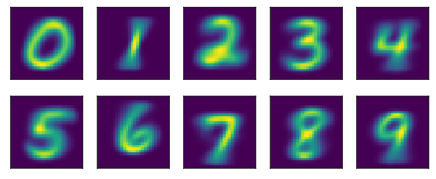

In [10]:
n_x = np.zeros((10, 28, 28))
for y in range(10):
    n_x[y] = np.array(X.asnumpy()[Y.asnumpy()==y].sum(axis=0))
P_xy = (n_x+1) / (n_y+1).reshape(10,1,1)

show_images(P_xy, 2, 5);

By visualizing these $10\times 28\times 28$ probabilities (for each pixel for each class) we could get some mean looking digits.  ...

Now we can use :eqref:`eq_naive_bayes_estimation` to predict a new image. Given $\mathbf x$, the following functions computes $p(\mathbf x|y)p(y)$ for every $y$.

In [11]:
np.expand_dims?

In [12]:
def bayes_pred(x):
    x = np.expand_dims(x, axis=0)  # (28, 28) -> (1, 28, 28)
    p_xy = P_xy * x + (1-P_xy)*(1-x)
    p_xy = p_xy.reshape(10,-1).prod(axis=1) # p(x|y)
    return np.array(p_xy) * P_y

image, label = mnist_test[0]
bayes_pred(image)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

This went horribly wrong! To find out why, let's look at the per pixel probabilities. They're typically numbers between $0.001$ and $1$. We are multiplying $784$ of them. At this point it is worth mentioning that we are calculating these numbers on a computer, hence with a fixed range for the exponent. What happens is that we experience *numerical underflow*, i.e. multiplying all the small numbers leads to something even smaller until it is rounded down to zero.

To fix this we use the fact that $\log a b = \log a + \log b$, i.e. we switch to summing logarithms.
Even if both $a$ and $b$ are small numbers, the logarithm values should be in a proper range.

In [13]:
a = 0.1
print('underflow:', a**784)
print('logrithm is normal:', 784*math.log(a))

underflow: 0.0
logrithm is normal: -1805.2267129073316


Since the logarithm is an increasing function, so we can rewrite :eqref:`eq_naive_bayes_estimation` as

$$ \hat{y} = \operatorname*{argmax}_y \> \sum_{i=1}^d \log P_{xy}[x_i, y] + \log P_y[y].$$

We can implement the following stable version:

In [14]:
log_P_xy = np.log(P_xy)
log_P_xy_neg = np.log(1-P_xy)
log_P_y = np.log(P_y)

def bayes_pred_stable(x):
    x = np.expand_dims(x, axis=0)  # (28, 28) -> (1, 28, 28)
    p_xy = log_P_xy * x + log_P_xy_neg * (1-x)
    p_xy = p_xy.reshape(10,-1).sum(axis=1) # p(x|y)
    return p_xy + log_P_y

py = bayes_pred_stable(image)
py

array([-269.00424, -301.73447, -245.21458, -218.8941 , -193.46907,
       -206.10315, -292.54315, -114.62834, -220.35619, -163.18881])

Check if the prediction is correct.

In [15]:
# convert label which is a scalar tensor of int32 dtype
# to a Python scalar integer for comparison
py.argmax(axis=0) == int(label)

array(1.)

Now predict a few validation examples, we can see the the Bayes
classifier works pretty well except for the 9th 16th digits.

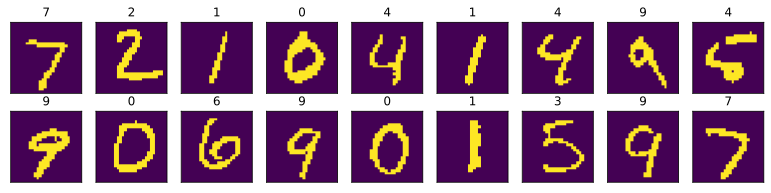

In [16]:
def predict(X):
    return [bayes_pred_stable(x).argmax(axis=0).astype(np.int32) for x in X]

X, y = mnist_test[:18]
preds = predict(X)
show_images(X, 2, 9, titles=[str(d) for d in preds]);

Finally, let's compute the overall accuracy of the classifier.

In [17]:
X, y = mnist_test[:]
preds = np.array(predict(X), dtype=np.int32)
'Validation accuracy', float((preds == y).sum()) / len(y)

('Validation accuracy', 0.8426)

Modern deep networks achieve error rates of less than 0.01. While Naive Bayes classifiers used to be popular in the 80s and 90s, e.g. for spam filtering, their heydays are over. The poor performance is due to the incorrect statistical assumptions that we made in our model: we assumed that each and every pixel are *independently* generated, depending only on the label. This is clearly not how humans write digits, and this wrong assumption led to the downfall of our overly naive (Bayes) classifier. Time to start building Deep Networks.

## Summary

* Naive Bayes is an easy to use classifier that uses the assumption
  $p(\mathbf{x} | y) = \prod_i p(x_i | y)$.
* The classifier is easy to train but its estimates can be very wrong.
* To address overly confident and nonsensical estimates, the
  probabilities $p(x_i|y)$ are smoothed, e.g. by Laplace
  smoothing. That is, we add a constant to all counts.
* Naive Bayes classifiers don't exploit any correlations between
  observations.

## Exercises

1. Design a Naive Bayes regression estimator where $p(x_i | y)$ is a normal distribution.
1. Under which situations does Naive Bayes work?
1. An eyewitness is sure that he could recognize the perpetrator with 90% accuracy, if he were to encounter him again.
   * Is this a useful statement if there are only 5 suspects?
   * Is it still useful if there are 50?

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2320)

![](../img/qr_naive-bayes.svg)